In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import yfinance as yf
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.utils.plotting import plot_series
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon

# import tensorflow as tf
# import tensorflow.keras.backend as K 
from joblib import dump, load
import random as rn
import os
# from tensorflow import set_random_seed
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from keras.layers import Dense, LSTM, LeakyReLU, Dropout, ReLU
# from keras.layers import Bidirectional

from tqdm import tqdm
import matplotlib.pyplot as plt



from vmdpy import VMD  

STEPS = 30



def smape(a, f):  #  smape score
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

In [2]:
data_btc_oh = yf.download(tickers='BTC-USD', start="2014-01-01", end="2023-09-21", interval = '1d', ).iloc[:, [0, 1, 2,3,5]]
data_btc_oh

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2023-07-30,29357.093750,29443.169922,29059.501953,29275.308594,8678454527
2023-07-31,29278.314453,29489.873047,29131.578125,29230.111328,11656781982
2023-08-01,29230.873047,29675.732422,28657.023438,29675.732422,18272392391


In [3]:
data_btc_oh.index = pd.Series(data_btc_oh.index.values)
data_btc_oh

,Open,High,Low,Close,Volume
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2023-07-30,29357.093750,29443.169922,29059.501953,29275.308594,8678454527
2023-07-31,29278.314453,29489.873047,29131.578125,29230.111328,11656781982
2023-08-01,29230.873047,29675.732422,28657.023438,29675.732422,18272392391
2023-08-02,29704.146484,29987.998047,28946.509766,29151.958984,19212655598


In [7]:
time_series_train, time_series_test = data_btc_oh[data_btc_oh.index <= "2022-03-01"]['Close'], data_btc_oh[data_btc_oh.index > "2022-03-01"]['Close']

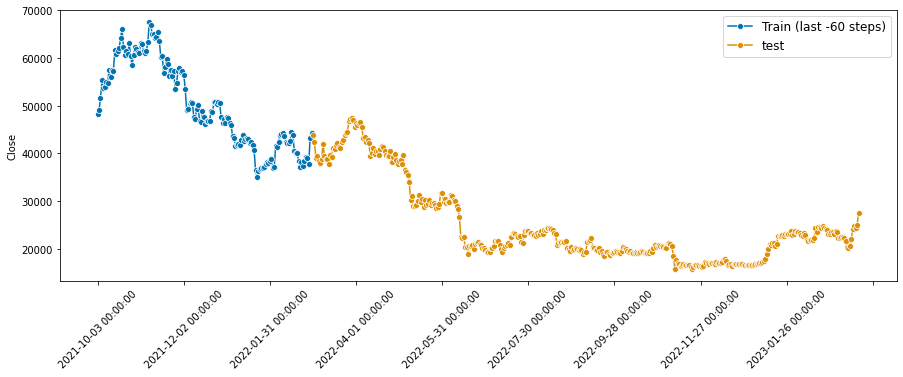

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))

plot_series(time_series_train[-STEPS * 5:], time_series_test, 
            labels=['Train (last {} steps)'.format(-STEPS * 2), 'test'], 
            ax=ax)

plt.legend(fontsize=12)
plt.xticks(rotation=45);

## VMD Decomposition

In [8]:
#. some sample parameters for VMD  
alpha = 3000       # moderate bandwidth constraint  
tau = 0.39    # noise-tolerance (no strict fidelity enforcement)  
Kk = 11             # 3 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7  


#. Run actual VMD code  
u, u_hat, omega = VMD(data_btc_oh['Close'].values, alpha, tau, Kk, DC, init, tol)  

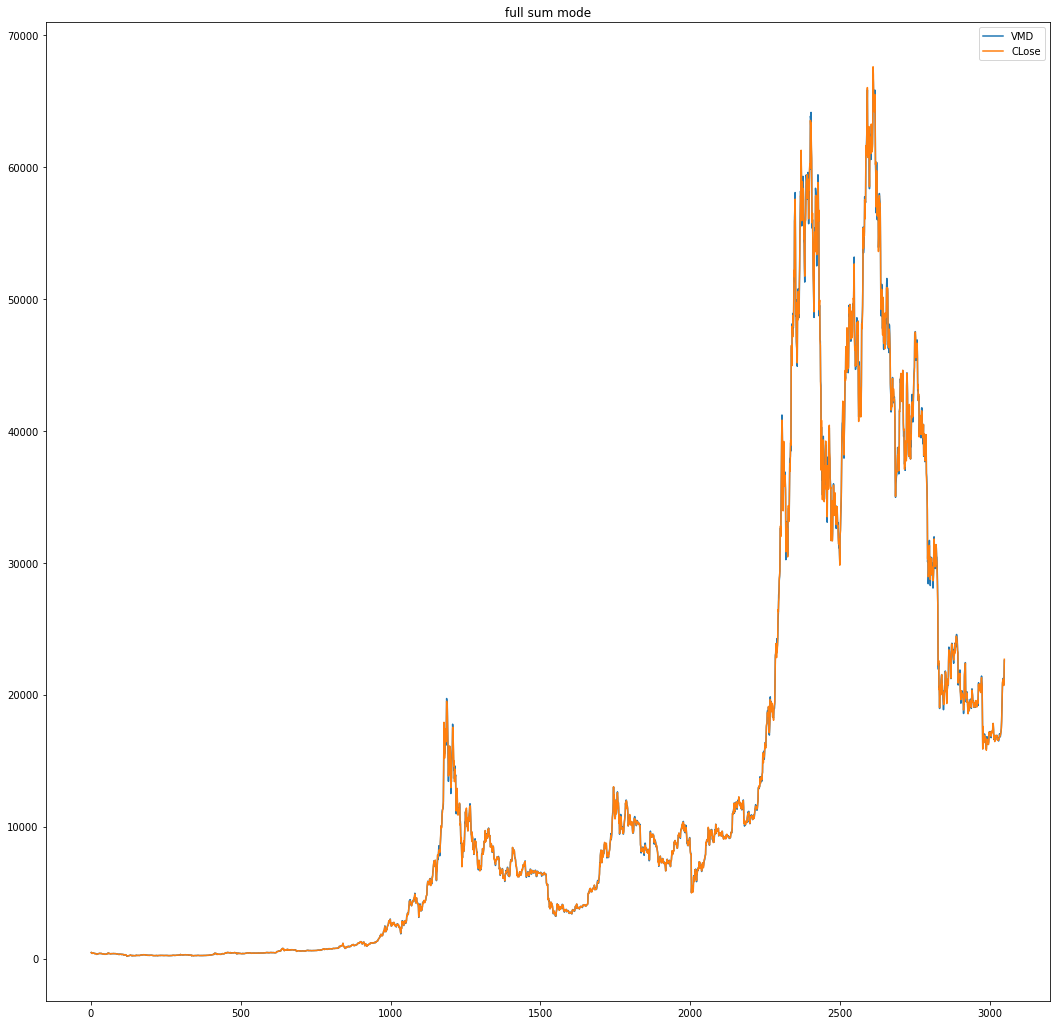

In [16]:
plt.figure(figsize=(18, 18))
plt.plot(np.arange(1, len(i) + 1), sum(u[:]), label='VMD')
plt.plot(np.arange(1, len(i) + 1), data_btc_oh['Close'], label='CLose')

plt.title(f'full sum mode')
plt.legend()
plt.show()
k += 1

In [17]:
data_vmd = pd.DataFrame(u).T
# data_vmd['Close'] = data_btc_oh['Close'].values

In [18]:
data_vmd

,0,1,2,3,4,5,6,7,8,9,10
0,310.951676,72.946493,26.006554,10.254783,7.030367,19.405500,7.409932,2.547967,1.959249,-0.802759,2.466381
1,310.752703,72.735223,25.570342,10.177711,4.763223,7.170789,-1.682508,-2.460048,-2.304675,3.312089,-2.396824
2,310.723012,72.691631,25.116330,10.469813,1.530486,-8.972311,-7.856880,-1.765948,-1.587162,-4.654712,2.228570
3,310.734925,72.687213,24.518178,10.906051,-1.896711,-19.319024,-4.464443,2.049547,3.852413,3.852419,-2.331366
4,310.701529,72.631460,23.678555,11.223959,-4.791538,-17.946986,3.281983,0.623371,-0.634847,-1.138556,2.759082
...,...,...,...,...,...,...,...,...,...,...,...
3043,17593.223066,926.878211,1671.216980,692.298880,288.801009,-189.123313,111.679390,198.702130,-120.582011,3.553212,51.747693
3044,17604.792443,950.611934,1781.526062,914.352713,127.636745,-273.152008,-256.517507,157.633430,137.875889,22.528761,-40.587986
3045,17612.269209,967.348684,1865.041500,1092.348500,-63.280067,-165.514677,-371.588346,-229.599576,22.353162,-27.250299,32.092514
3046,17621.458609,982.958316,1926.717562,1223.797252,-217.247111,74.464955,-52.755046,-200.307234,-171.268443,12.456067,-25.104866


In [19]:
data_vmd = pd.concat([data_vmd, data_btc_oh.reset_index(drop=True)], axis=1)
data_vmd

,0,1,2,3,4,5,6,7,8,9,10,Open,High,Low,Close,Volume
0,310.951676,72.946493,26.006554,10.254783,7.030367,19.405500,7.409932,2.547967,1.959249,-0.802759,2.466381,465.864014,468.174011,452.421997,457.334015,21056800
1,310.752703,72.735223,25.570342,10.177711,4.763223,7.170789,-1.682508,-2.460048,-2.304675,3.312089,-2.396824,456.859985,456.859985,413.104004,424.440002,34483200
2,310.723012,72.691631,25.116330,10.469813,1.530486,-8.972311,-7.856880,-1.765948,-1.587162,-4.654712,2.228570,424.102997,427.834991,384.532013,394.795990,37919700
3,310.734925,72.687213,24.518178,10.906051,-1.896711,-19.319024,-4.464443,2.049547,3.852413,3.852419,-2.331366,394.673004,423.295990,389.882996,408.903992,36863600
4,310.701529,72.631460,23.678555,11.223959,-4.791538,-17.946986,3.281983,0.623371,-0.634847,-1.138556,2.759082,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,17593.223066,926.878211,1671.216980,692.298880,288.801009,-189.123313,111.679390,198.702130,-120.582011,3.553212,51.747693,20882.224609,21360.875000,20715.746094,21169.632812,26792494050
3044,17604.792443,950.611934,1781.526062,914.352713,127.636745,-273.152008,-256.517507,157.633430,137.875889,22.528761,-40.587986,21175.833984,21438.660156,20978.533203,21161.519531,24999983362
3045,17612.269209,967.348684,1865.041500,1092.348500,-63.280067,-165.514677,-371.588346,-229.599576,22.353162,-27.250299,32.092514,21161.050781,21564.501953,20541.544922,20688.781250,30005625418
3046,17621.458609,982.958316,1926.717562,1223.797252,-217.247111,74.464955,-52.755046,-200.307234,-171.268443,12.456067,-25.104866,20686.746094,21163.011719,20685.380859,21086.792969,21152848261


In [21]:
COL = list(data_vmd.columns[:-5]) + [ 'Open',   'High',    'Low',
        'Volume',  'Close' ]
print(COL)
data_vmd = data_vmd[COL]

In [23]:
data_vmd['resists'] = np.sum(data_vmd.iloc[:, 1:11], axis=1)
data_vmd

,0,1,2,3,4,5,6,7,8,9,10,Open,High,Low,Volume,Close,resists
0,310.951676,72.946493,26.006554,10.254783,7.030367,19.405500,7.409932,2.547967,1.959249,-0.802759,2.466381,465.864014,468.174011,452.421997,21056800,457.334015,149.224469
1,310.752703,72.735223,25.570342,10.177711,4.763223,7.170789,-1.682508,-2.460048,-2.304675,3.312089,-2.396824,456.859985,456.859985,413.104004,34483200,424.440002,114.885323
2,310.723012,72.691631,25.116330,10.469813,1.530486,-8.972311,-7.856880,-1.765948,-1.587162,-4.654712,2.228570,424.102997,427.834991,384.532013,37919700,394.795990,87.199817
3,310.734925,72.687213,24.518178,10.906051,-1.896711,-19.319024,-4.464443,2.049547,3.852413,3.852419,-2.331366,394.673004,423.295990,389.882996,36863600,408.903992,89.854275
4,310.701529,72.631460,23.678555,11.223959,-4.791538,-17.946986,3.281983,0.623371,-0.634847,-1.138556,2.759082,408.084991,412.425995,393.181000,26580100,398.821014,89.686482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043,17593.223066,926.878211,1671.216980,692.298880,288.801009,-189.123313,111.679390,198.702130,-120.582011,3.553212,51.747693,20882.224609,21360.875000,20715.746094,26792494050,21169.632812,3635.172180
3044,17604.792443,950.611934,1781.526062,914.352713,127.636745,-273.152008,-256.517507,157.633430,137.875889,22.528761,-40.587986,21175.833984,21438.660156,20978.533203,24999983362,21161.519531,3521.908034
3045,17612.269209,967.348684,1865.041500,1092.348500,-63.280067,-165.514677,-371.588346,-229.599576,22.353162,-27.250299,32.092514,21161.050781,21564.501953,20541.544922,30005625418,20688.781250,3121.951396
3046,17621.458609,982.958316,1926.717562,1223.797252,-217.247111,74.464955,-52.755046,-200.307234,-171.268443,12.456067,-25.104866,20686.746094,21163.011719,20685.380859,21152848261,21086.792969,3553.711453


In [2]:
# prepare data for Hybrid model arima-catboost

data_cat_arima = data_vmd[[0, 'resists']]
data_cat_arima

# ARIMA?-Catboost

In [4]:
# add close column for validation

data_cat_arima.columns = ['for_arima', 'for_gb']
data_cat_arima['Close'] = data_vmd['Close']
data_cat_arima

In [ ]:
data_cat_arima.index = data_btc_oh.index

In [ ]:
data_cat_arima.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-01-11', '2023-01-12', '2023-01-13', '2023-01-14',
               '2023-01-15', '2023-01-16', '2023-01-17', '2023-01-18',
               '2023-01-19', '2023-01-20'],
              dtype='datetime64[ns]', length=3048, freq=None)

In [ ]:
data_cat_arima

,for_arima,for_gb,Close
2014-09-17,310.951676,149.224469,457.334015
2014-09-18,310.752703,114.885323,424.440002
2014-09-19,310.723012,87.199817,394.795990
2014-09-20,310.734925,89.854275,408.903992
2014-09-21,310.701529,89.686482,398.821014
...,...,...,...
2023-01-16,17593.223066,3635.172180,21169.632812
2023-01-17,17604.792443,3521.908034,21161.519531
2023-01-18,17612.269209,3121.951396,20688.781250
2023-01-19,17621.458609,3553.711453,21086.792969


In [ ]:
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=1231, silent=True, iterations=600),
                lags      = 60 # This value will be replaced in the grid search
             )

In [5]:
# grid for determining lag for Catboost
# lags_grid = range(30, 171, 20)

# # Regressor's hyperparameters

# param_grid= {
#     'max_depth': [3,5,7,9],
#     }

# results_grid = grid_search_forecaster(
#                         forecaster         = forecaster,
#                         y                  = data_cat_arima['for_gb'].loc[time_series_train.index],
#                  |       param_grid         = param_grid,
#                         lags_grid          = lags_grid,
#                         steps              = STEPS,
#                         refit              = True,
#                         metric             = 'mean_squared_error',
#                         initial_train_size = int(len(time_series_train)*0.8),
#                         fixed_train_size   = False,
#                         return_best        = True,
#                         verbose            = False
#                )


# print(results_grid.values[0])
# print(results_grid.values[1])

In [44]:
def sarima_part(arima_train,s=12):
    """ Function for predictiong with ARIMA"""
    
    arima_train=np.log(arima_train)
    model_autoARIMA = auto_arima(arima_train, start_p=1, start_q=1,max_d=2,
                           max_p=3, max_q=3, m=s,
                           start_P=2, seasonal=True,
                           d=1,D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    model_autoARIMA.fit(arima_train)
    fc=model_autoARIMA.predict(STEPS)
    forecast=np.exp(fc)
    return forecast

In [45]:
# Forecaster for predicting resists with Catboost regressor

forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=1231, silent=True),
                lags      = 170 # This value will be replaced in the grid search
             )

In [46]:
def make_full_validation_of_hybrid(data, forecaster_cat):
    
    """ Function for training, predicting and validating """
    
    
    tscv = TimeSeriesSplit(test_size=STEPS, n_splits = 10)
    all_smapes = []
    all_mae = []
    all_mda = []
    

    for i, (train_index, test_index) in enumerate(tscv.split(data)):
        #print(train_index)
        
        test_data_ = data.loc[:, 'Close'].iloc[test_index]
        train_data_arima = data.loc[:, 'for_arima'].iloc[train_index]
        train_data_cat = data.loc[:, 'for_gb'].iloc[train_index]

        pred_arima = pd.Series(sarima_part(train_data_arima), index=test_data_.index)
        
    
        
        forecaster_cat.fit(y=train_data_cat)


        time_series_pred = pd.Series(forecaster_cat.predict(steps=STEPS))
       
        time_series_pred.index = pred_arima.index
        
        total_predict = pred_arima + time_series_pred
        
        
        fig, ax = plt.subplots(figsize=(15, 5))

        plot_series(data.iloc[train_index].iloc[-50:, -1], test_data_, total_predict,
                    labels=['Train (last {} steps)'.format(-STEPS * 2), 'test', 'pred_gybrid'],
                   ax=ax)

        ax.get_lines()[2].set_color("salmon")
        ax.xaxis.set_label_position('top') 

        plt.legend()
        plt.xticks(rotation=45)
        plt.show()
        
        smape_ = smape(test_data_.values, total_predict.values)
        mae_ = mean_absolute_error(test_data_.values, total_predict.values)
        mda_ = mda(test_data_.values, total_predict.values)
        
        
        
        all_smapes.append(smape_)
        all_mae.append(mae_)
        all_mda.append(mda_)



        print(f"Fold {i}: \nSMAPE = {smape_:.2f}, MAE = {mae_:.2f}, MDA={mda_:.2f}")

    
    print(f'\nFINALE: SMAPE Mean: {np.mean(all_smapes):.2f}, MAE Mean {np.mean(all_mae):.2f}, MDA {np.mean(all_mda):.2f}' )


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-35976.888, Time=7.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-29192.455, Time=0.50 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-35055.640, Time=1.74 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-29189.913, Time=2.42 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-35947.103, Time=1.82 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-35652.879, Time=2.43 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=16.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-35640.007, Time=1.74 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-33475.605, Time=11.42 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-29233.573, Time=3.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-35471.811, Time=6.38 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-35783.641, Time=6.29 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-36197.257, Time=4.56 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=-36126.809, Time=5.45 

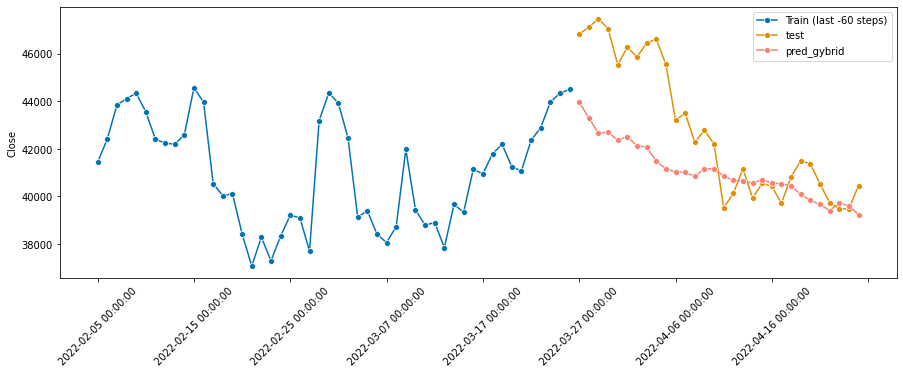

Fold 0: 
SMAPE = 4.58, MAE = 1982.29, MDA=0.59
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-36376.347, Time=18.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-29526.095, Time=0.58 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-35454.757, Time=2.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-29523.683, Time=3.58 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-36347.619, Time=3.63 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-36049.816, Time=4.59 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=26.31 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-36040.256, Time=3.71 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-33826.708, Time=11.86 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-29568.751, Time=9.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-35809.591, Time=8.80 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-36182.604, Time=9.61 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-36600.437, Time=15.62 sec
 ARIMA(1,1,2)(1,

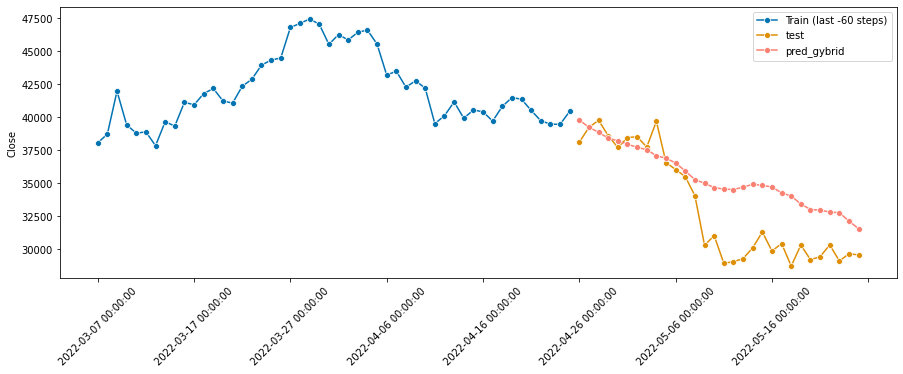

Fold 1: 
SMAPE = 8.02, MAE = 2606.18, MDA=0.66
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-36779.525, Time=6.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-29845.659, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-35851.703, Time=1.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-29845.528, Time=1.85 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-36752.011, Time=2.97 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-36457.484, Time=4.79 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=10.62 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-36447.754, Time=2.65 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-34217.191, Time=4.37 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-29892.308, Time=3.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-36628.107, Time=9.68 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-37004.357, Time=6.81 sec
 ARIMA(1,1,2)(1,1,1)[12]   

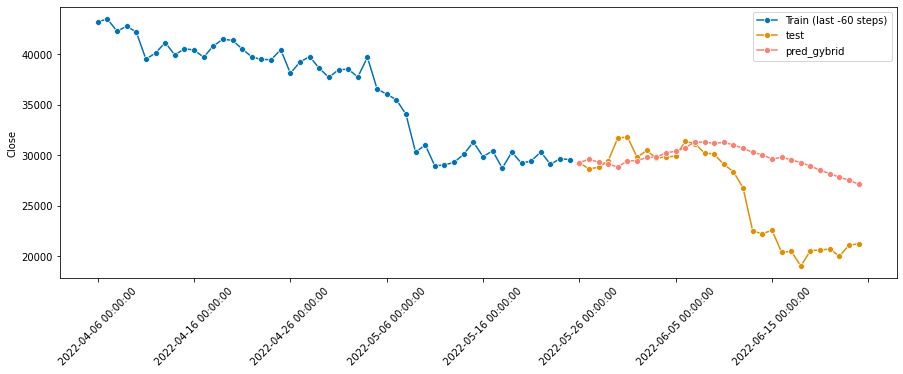

Fold 2: 
SMAPE = 15.09, MAE = 3871.10, MDA=0.52
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-37221.888, Time=4.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-30159.638, Time=0.47 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-36241.962, Time=1.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-30157.716, Time=2.65 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-37188.956, Time=3.00 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-36870.839, Time=7.37 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=20.96 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-36856.800, Time=1.50 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-34648.218, Time=5.75 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-30202.719, Time=5.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-36698.101, Time=11.89 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-37068.575, Time=8.55 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-37440.647, Time=7.34 sec
 ARIMA(1,1,2)(1,1

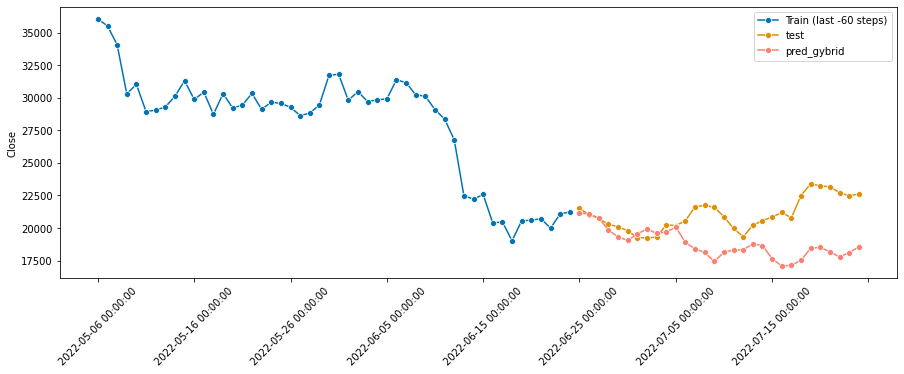

Fold 3: 
SMAPE = 11.61, MAE = 2317.82, MDA=0.62
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-37606.774, Time=4.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-30489.819, Time=0.46 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-36644.604, Time=2.83 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-30494.155, Time=1.41 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-37573.919, Time=3.73 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-37286.978, Time=10.33 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=19.96 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-37266.619, Time=1.40 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-34986.772, Time=8.55 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-30548.906, Time=4.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-37010.375, Time=3.98 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-37401.214, Time=5.75 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-37829.072, Time=7.61 sec
 ARIMA(1,1,2)(1,1

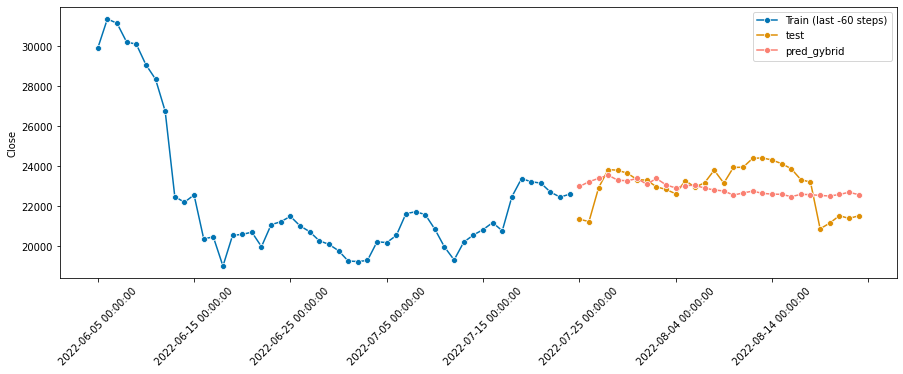

Fold 4: 
SMAPE = 3.94, MAE = 898.89, MDA=0.62
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-38022.640, Time=4.86 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-30832.813, Time=0.42 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-37051.036, Time=2.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-30837.756, Time=2.52 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-37989.650, Time=3.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-37701.113, Time=10.04 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=30.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-37679.104, Time=3.66 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-35421.220, Time=4.80 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-30892.739, Time=7.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-37487.209, Time=7.32 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-38249.001, Time=7.40 sec
 ARIMA(1,1,2)(1,1,1)[12]   

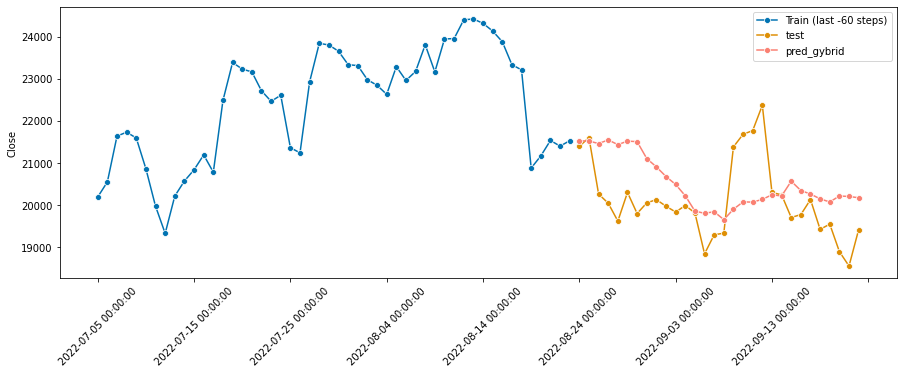

Fold 5: 
SMAPE = 4.35, MAE = 887.61, MDA=0.59
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-38440.000, Time=4.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-31178.298, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-37453.731, Time=2.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-31183.066, Time=2.33 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-38404.234, Time=2.13 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-38108.220, Time=6.53 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=11.89 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-38088.558, Time=4.49 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-35887.347, Time=6.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-31238.562, Time=7.84 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-37900.438, Time=7.04 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-38277.942, Time=9.68 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-38669.146, Time=7.33 sec
 ARIMA(1,1,2)(1,1,1)

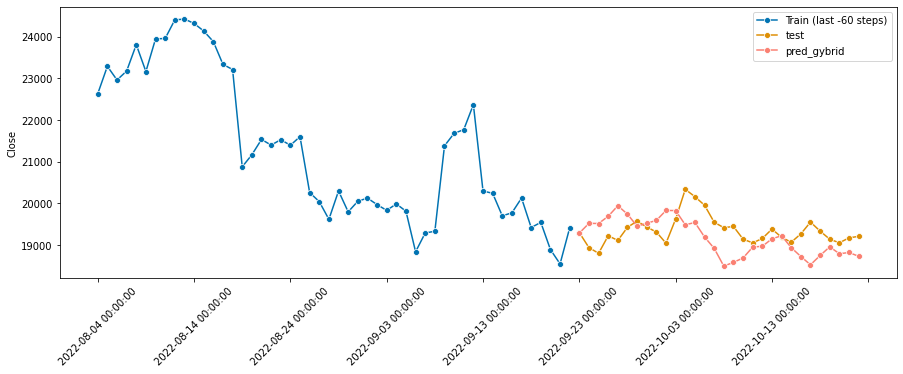

Fold 6: 
SMAPE = 2.36, MAE = 453.95, MDA=0.55
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-38853.500, Time=4.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-31518.859, Time=0.42 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-37857.647, Time=2.88 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-31523.214, Time=1.46 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-38815.920, Time=3.91 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-38517.727, Time=6.93 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=35.17 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-38494.329, Time=2.25 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-36266.638, Time=13.73 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-31578.689, Time=4.84 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-38309.931, Time=3.74 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-38641.443, Time=5.96 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-39085.600, Time=13.20 sec
 ARIMA(1,1,2)(1,1,

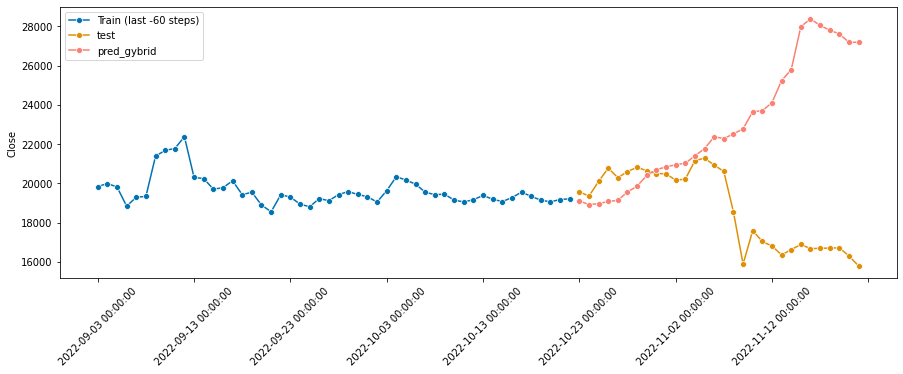

Fold 7: 
SMAPE = 21.92, MAE = 4684.31, MDA=0.41
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-39263.353, Time=3.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-31855.799, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-38261.065, Time=2.78 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-31861.875, Time=1.98 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-39229.215, Time=2.52 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-38929.262, Time=7.32 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=13.42 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-38904.288, Time=2.44 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-36680.428, Time=8.91 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-31920.817, Time=5.80 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-38715.663, Time=6.66 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-39098.080, Time=11.45 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-39497.287, Time=5.00 sec
 ARIMA(1,1,2)(1,1

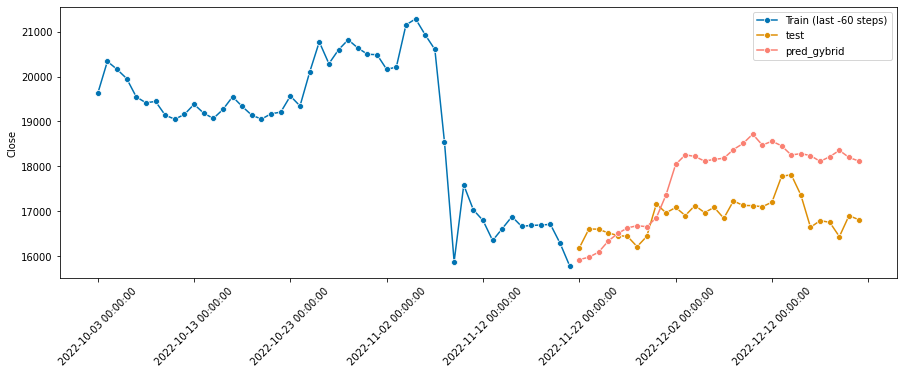

Fold 8: 
SMAPE = 5.32, MAE = 930.53, MDA=0.48
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-39648.236, Time=4.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-32182.659, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-38659.800, Time=2.60 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-32190.834, Time=1.65 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-39618.025, Time=2.13 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-39332.408, Time=13.08 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=22.29 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-39313.483, Time=4.73 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-37041.086, Time=16.01 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-32258.920, Time=7.00 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=-39096.914, Time=10.36 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-39434.183, Time=3.43 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-39889.146, Time=11.69 sec
 ARIMA(1,1,2)(1,

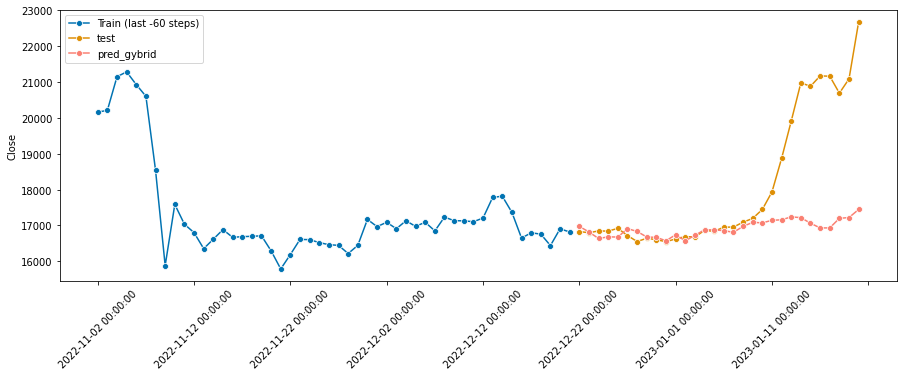

Fold 9: 
SMAPE = 6.42, MAE = 1212.09, MDA=0.41

FINALE: SMAPE Mean: 8.36, MAE Mean 1984.48, MDA 0.54


In [ ]:
make_full_validation_of_hybrid(data_cat_arima, forecaster)